In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process.kernels import RBF
import sys
sys.path.append("/home/leon/projects/gaussian_process/")
from gaussian_process_visualisation import visualise_1D_gaussian_process, visualise_2D_gaussian_process
from gaussian_process_hyperparameter_tuning import optimise_hyperparameters


In [2]:
path = "/home/leon/learning/gaussian-processes/bank/bank-full.csv"
data = pd.read_csv(path, sep=";")
one_hot_encode = ["job", "marital", "education", "contact", "poutcome", "month"]
binary = ["default", "housing", "loan", "y"]

In [3]:
enc = OneHotEncoder()
def yesNoBinary(column):
    return(pd.DataFrame([1 if value == "yes" else 0 for value in column], columns = [column.name]))
one_hot = pd.DataFrame(enc.fit_transform(data[one_hot_encode]).toarray(), columns=enc.get_feature_names_out(one_hot_encode))
data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
X, y = data2.values[:,:-1], data2.values[:,-1]

/tmp/ipykernel_20413/915973979.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
/tmp/ipykernel_20413/915973979.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)


In [10]:
hyperparameters = [
    [("weights", ['uniform', 'distance'])],
    [("n_neighbors", np.arange(4, 100, 1)),
     ("leaf_size", np.arange(5, 100, 5))]
]

hyperparameters = [
    [("boosting", ["gbdt"])],
    [
        ("lambda_l1", list((np.logspace(0.00, 1, 50) -1)/9)),
        ("num_leaves", [int(x) for x in np.arange(10, 200, 1)]),
    ],
]

In [12]:
kernel = RBF(1.0)
(best_configurations, best_scores), gp_datas = optimise_hyperparameters(LGBMClassifier, hyperparameters, 100, X, y, 10, kernel=kernel)

[LightGBM] [Warning] lambda_l1 is set=0.32299332633940186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32299332633940186
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.32299332633940186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32299332633940186
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.32299332633940186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32299332633940186
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.32299332633940186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32299332633940186
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_

/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[LightGBM] [Warning] lambda_l1 is set=0.2840533673581254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2840533673581254
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.2840533673581254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2840533673581254
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.2840533673581254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2840533673581254
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.2840533673581254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2840533673581254
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is se

/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[LightGBM] [Warning] lambda_l1 is set=0.6885396366679466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6885396366679466
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.6885396366679466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6885396366679466
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.6885396366679466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6885396366679466
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.6885396366679466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6885396366679466
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is se

{'lambda_l1': [0.0,
  0.005345903794965073,
  0.01094901577639535,
  0.016821711036271933,
  0.022976960071036508,
  0.029428357428366223,
  0.03619015173223435,
  0.043277277152570855,
  0.05070538638902709,
  0.058490885241692596,
  0.06665096884511756,
  0.07520365964566755,
  0.08416784720608798,
  0.09356332992519066,
  0.10341085876480556,
  0.113732183080573,
  0.12455009865779898,
  0.1358884980584661,
  0.1477724233905969,
  0.16022812161651678,
  0.17328310252217063,
  0.18696619947552506,
  0.2013076331082478,
  0.21633907806131228,
  0.23209373294194233,
  0.2486063936464049,
  0.265913530210592,
  0.2840533673581254,
  0.3030659689238822,
  0.32299332633940186,
  0.3438794513756027,
  0.36577047334764196,
  0.388714740996605,
  0.41276292927304375,
  0.43796815125820376,
  0.46438607547013444,
  0.49207504881376213,
  0.5210962254464773,
  0.5515137018438492,
  0.5833946583637746,
  0.616809507621723,
  0.6518320500047777,
  0.6885396366679466,
  0.7270133403727352,
  0.76

In [19]:
from sklearn.model_selection import RandomizedSearchCV
classifier = LGBMClassifier()
gs = RandomizedSearchCV(classifier, dict(hyperparameters[1]), n_iter=100)
gs.fit(X, y)

[LightGBM] [Warning] lambda_l1 is set=0.43796815125820376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43796815125820376
[LightGBM] [Warning] lambda_l1 is set=0.43796815125820376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43796815125820376
[LightGBM] [Warning] lambda_l1 is set=0.43796815125820376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43796815125820376
[LightGBM] [Warning] lambda_l1 is set=0.43796815125820376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43796815125820376
[LightGBM] [Warning] lambda_l1 is set=0.43796815125820376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43796815125820376
[LightGBM] [Warning] lambda_l1 is set=0.10341085876480556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10341085876480556
[LightGBM] [Warning] lambda_l1 is set=0.10341085876480556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10341085876480556
[LightGBM] [Warning] lambda_l1 is set=0.103410858764805

RandomizedSearchCV(estimator=LGBMClassifier(), n_iter=100,
                   param_distributions={'lambda_l1': [0.0, 0.005345903794965073,
                                                      0.01094901577639535,
                                                      0.016821711036271933,
                                                      0.022976960071036508,
                                                      0.029428357428366223,
                                                      0.03619015173223435,
                                                      0.043277277152570855,
                                                      0.05070538638902709,
                                                      0.058490885241692596,
                                                      0.06665096884511756,
                                                      0.07520365964566755,
                                                      0.08416784720608798,
                                                      0.0935633...
                                                      0.1358884980584661,
                                                      0.1477724233905969,
                                                      0.16022812161651678,
                                                      0.17328310252217063,
                                                      0.18696619947552506,
                                                      0.2013076331082478,
                                                      0.21633907806131228,
                                                      0.23209373294194233,
                                                      0.2486063936464049,
                                                      0.265913530210592,
                                                      0.2840533673581254,
                                                      0.3030659689238822,
                                                      0.32299332633940186, ...],
                                        'num_leaves': [10, 11, 12, 13, 14, 15,
                                                       16, 17, 18, 19, 20, 21,
                                                       22, 23, 24, 25, 26, 27,
                                                       28, 29, 30, 31, 32, 33,
                                                       34, 35, 36, 37, 38, 39, ...]})

In [20]:
from sklearn.model_selection import cross_val_score

knn_bayes = LGBMClassifier(**best_configurations[0])
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))

knn_gs = LGBMClassifier(**gs.best_params_)
score_gs = np.mean(cross_val_score(knn_gs, X, y, cv=5))
#score_gs= "None"
knn_default = LGBMClassifier()
score_default = np.mean(cross_val_score(knn_default, X, y, cv=5))
print(f"bayesian: {score_bayes}, random search: {score_gs}, default: {score_default}")


[LightGBM] [Warning] lambda_l1 is set=0.7270133403727352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7270133403727352
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.7270133403727352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7270133403727352
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.7270133403727352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7270133403727352
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.7270133403727352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7270133403727352
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is se

dict_keys(['gbdt'])

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils.extmath import cartesian
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

gaussian = GaussianProcessRegressor(kernel=kernel)
#gaussian.fit(result['uniform'][0], result['uniform'][0].dot(np.array([1.0, 3.0]))/500)
gaussian.fit(gp_datas['gbdt'][0], gp_datas['gbdt'][1])

GaussianProcessRegressor(kernel=RBF(length_scale=1))

In [28]:
hyperparameters[1][1][1]

[10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191

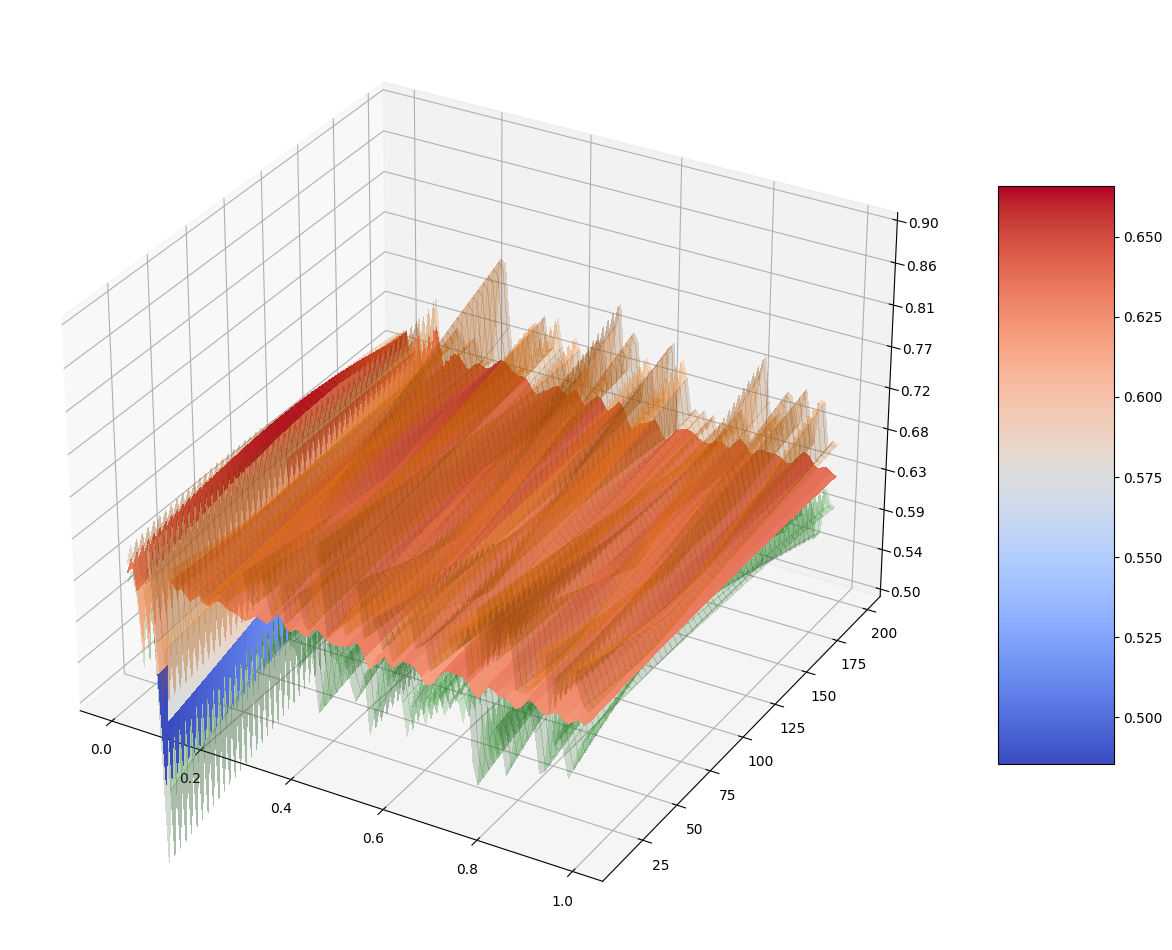

In [34]:
visualise_2D_gaussian_process(gaussian, (np.logspace(0.00, 1, 50) -1)/9, np.arange(10, 200, 1), np.arange(0.5, 1, 0.1))